In [1]:
 ! pip install -q kaggle
 from google.colab import files
 from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Get kaggle token and downaload dataset

In [3]:
# ! mkdir ~/.kaggle
# ! cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# ! kaggle datasets download jerzydziewierz/bee-vs-wasp --unzip

In [5]:
# ! cp -a  /content/kaggle_bee_vs_wasp /content/gdrive/MyDrive/

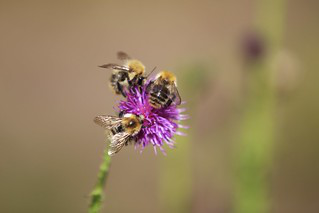

In [6]:
import PIL
import PIL.Image
PIL.Image.open("/content/gdrive/MyDrive/kaggle_bee_vs_wasp/bee1/10166485783_9cd6706c72_n.jpg")

In [7]:
pip install fastai --upgrade &> /dev/null # &> /dev/null - hides output

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision.all import *
from fastai.metrics import error_rate

# additional classic imports
from pathlib import Path
import pandas as pd
import numpy as np
import random

In [9]:
bs = 64 # Batch size
resize_size = 192 # for training, resize all the images to a square of this size
training_subsample = 0.5 # for development, use a small fraction of the entire dataset

In [10]:
bees_vs_wasps_dataset_path=Path('/content/gdrive/MyDrive/kaggle_bee_vs_wasp/') 
df_labels = pd.read_csv(bees_vs_wasps_dataset_path/'labels.csv')
df_labels=df_labels.set_index('id')

In [11]:
df_labels = df_labels.sample(frac=training_subsample, axis=0)
df_labels.size

51390

In [12]:
df_labels[['path']] = df_labels[['path']].replace(to_replace= r'\\', value= r'/', regex=True)
df_labels.head(10)


,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
id,,,,,,,,,
4055,wasp1/320365893_6e607d211a_n.jpg,0,1,0,0,1,0,0,wasp
6593,wasp2/H00246.jpg,0,1,0,0,0,0,0,wasp
8776,other_insect/27119000067_9838b2e6c4_n.jpg,0,0,1,0,1,0,0,insect
7805,wasp2/W00190.jpg,0,1,0,0,0,0,0,wasp
107,bee1/14002344549_67c6ba6a35_w.jpg,1,0,0,0,1,0,0,bee
10073,other_insect/5594497329_5116caf984_m.jpg,0,0,1,0,1,0,1,insect
8852,other_insect/28206240259_81fbd94356_n.jpg,0,0,1,0,1,0,0,insect
6367,wasp2/H00020.jpg,0,1,0,0,0,1,0,wasp
1117,bee1/3625373228_94c319294c_m.jpg,1,0,0,0,1,0,0,bee


In [13]:
data = ImageDataLoaders.from_df(
    df = df_labels,
    path = Path(bees_vs_wasps_dataset_path),
    valid_pct=0.2,
    seed = 5,
    fn_col='path',
    folder=None,
    label_col='label',
    bs=bs,
    shuffle_train=True,
    batch_tfms=aug_transforms(),
    item_tfms=Resize(resize_size),
    device='cuda', 
    num_workers=0
)

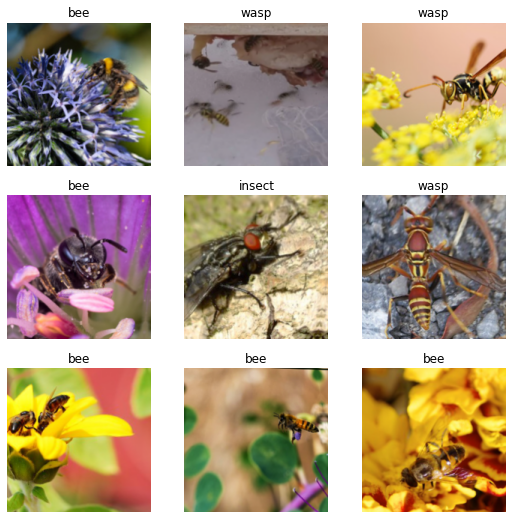

In [14]:
data.show_batch()

In [15]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, pretrained=true)
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage0')
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 96 x 96   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 48 x 48  
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

0.006309573352336883 0.0003414548991713673


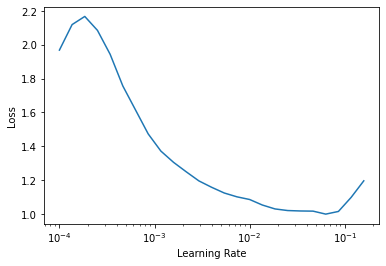

In [16]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage0')
best, step = learn.recorder.lr_find(start_lr=1e-04, end_lr=1, num_it=30) 
print(best, step)

In [17]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, pretrained=true)
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage0')
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 96 x 96   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 48 x 48  
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

Model frozen up to parameter group #2 - training only fully contected classifying layers

fit_one_cycle - uses cyclical learning rates

* https://arxiv.org/abs/1506.01186
* https://iconof.com/1cycle-learning-rate-policy/
* https://course.fast.ai/videos/?lesson=6 - learning rate, transfer learning



# Make trainable -fully connected layers - classification - Total trainable params: 2,161,536

In [18]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage0')
learn.recorder.fit_one_cycle(2, lr_max=slice(1e-4,1e-2)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.476220,0.257389,0.929072,01:27
1,0.278736,0.193663,0.943958,01:27


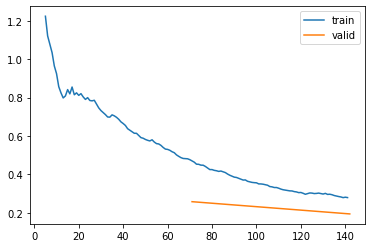

In [19]:
learn.recorder.plot_loss()

In [20]:
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage1')

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage1.pth')

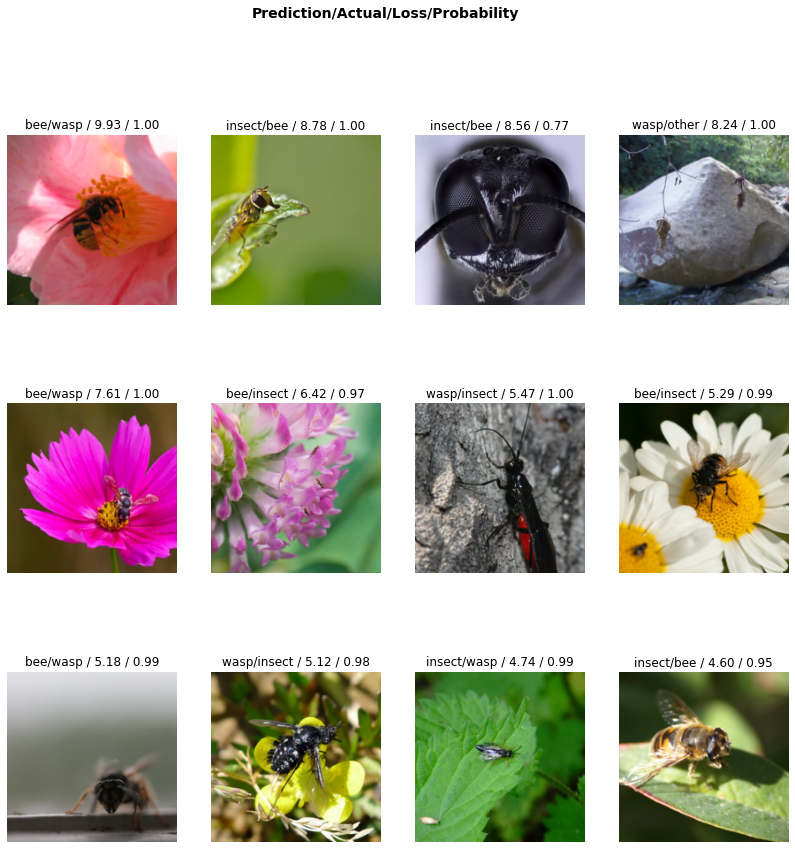

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(12, figsize=(14,14))

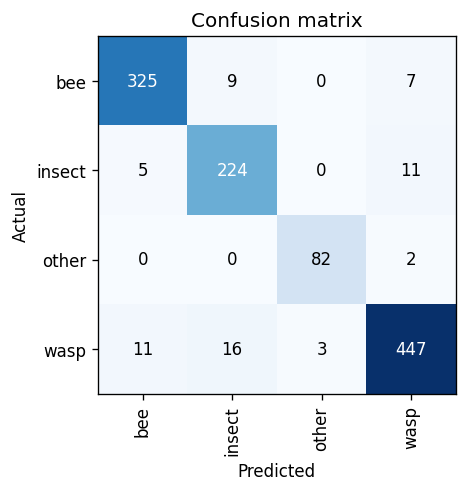

In [22]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

In [23]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage1')

https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/

https://medium.com/analytics-vidhya/understanding-fastai-v2-training-with-a-computer-vision-example-part-3-fastai-learner-and-a3ea85c6fe78

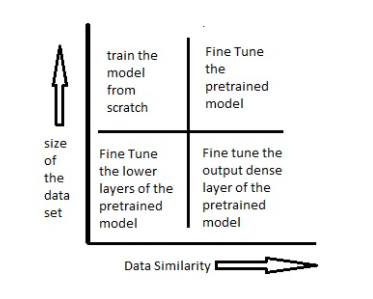

In [24]:
def setTrainable(isTrainable, id1, id2, id3, layerName):
  for name, child in learn.model.named_children():
    if name == id1:
      for name, child in child.named_children():
        if name == id2:
          for name, child in child.named_children():
            if name == id3:
              for name, child in child.named_children():
                if name == layerName:
                  for param in child.parameters():
                    params.requires_grad = isTrainable

def isTrainable(id1, id2, id3, layerName):
  for name, child in learn.model.named_children():
    if name == id1:
      for name, child in child.named_children():
        if name == id2:
          for name, child in child.named_children():
            if name == id3:
              for name, child in child.named_children():
                if name == layerName:
                  for param in child.parameters():
                    return params.requires_grad

https://realpython.com/introduction-to-python-generators/

In [25]:
# setTrainable(True, '0', '7', '2', 'conv3')
# isTrainable('0', '7', '2', 'conv3')

In [26]:
learn.model[0][7][2]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

# Make trainable - last conv layer - Total trainable params: 3,210,112


In [27]:
# for param in learn.model.parameters():
#   param.requires_grad = False

learn.freeze()

for param in learn.model[0][7][2].conv3.parameters():
  param.requires_grad = True
 
for param in learn.model[0][7][2].bn3.parameters():
  param.requires_grad = True

learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage2')
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 96 x 96   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 48 x 48  
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

6.30957356406725e-07 1.4677992510314652e-07


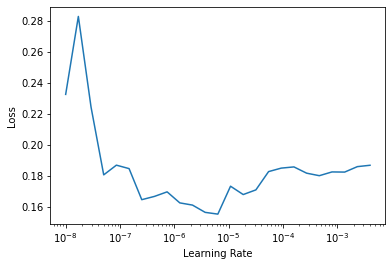

In [28]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage2')
best, step = learn.recorder.lr_find(start_lr=1e-08, end_lr=1e-01, num_it=30) 
print(best, step)

epoch,train_loss,valid_loss,accuracy,time
0,0.176815,0.195783,0.940455,01:25


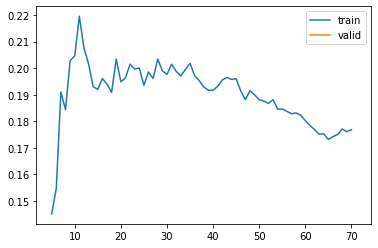

In [31]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage2')
learn.recorder.fit_one_cycle(1, lr_max=slice(1e-8,1e-6)) 
learn.recorder.plot_loss()

In [32]:
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage3')

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage3.pth')

In [33]:
learn.freeze()

for param in learn.model[0][7][2].conv2.parameters():
  param.requires_grad = True

for param in learn.model[0][7][2].bn2.parameters():
  param.requires_grad = True  

for param in learn.model[0][7][2].conv3.parameters():
  param.requires_grad = True
 
for param in learn.model[0][7][2].bn3.parameters():
  param.requires_grad = True

learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage3')
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 96 x 96   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 48 x 48  
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

# Make trainable - last 2 conv layers - Total trainable params: 5,569,408

0.00023263050243258477 7.356422315751843e-07


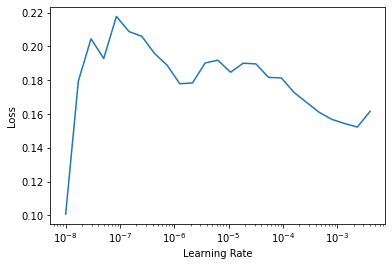

In [34]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage3')
best, step = learn.recorder.lr_find(start_lr=1e-08, end_lr=1e-01, num_it=30) 
print(best, step)

epoch,train_loss,valid_loss,accuracy,time
0,0.180771,0.164957,0.952715,01:25


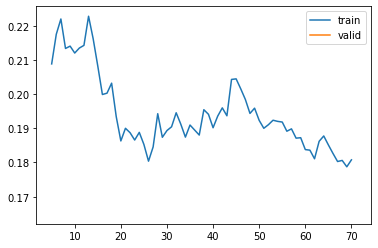

In [36]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage3')
learn.recorder.fit_one_cycle(1, lr_max=slice(1e-5,1e-3)) 
learn.recorder.plot_loss()

In [37]:
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage4')

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage4.pth')

Unfreeze all layers - whole net trainable

3.981071640737355e-05 2.5118864765971693e-09


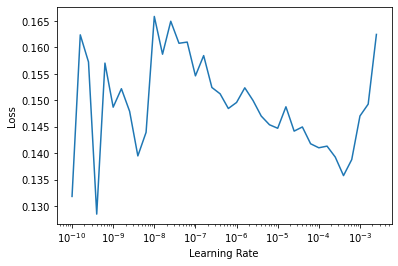

In [39]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage4')
learn.unfreeze()
best, step = learn.recorder.lr_find(start_lr=1e-10, end_lr=1, num_it=50) 
print(best, step)

epoch,train_loss,valid_loss,accuracy,time
0,0.153899,0.164715,0.953590,01:35


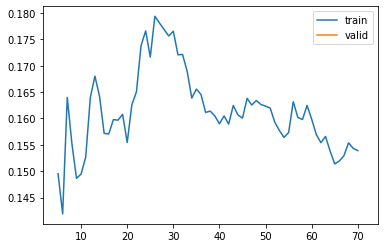

In [41]:
learn.load('/content/gdrive/MyDrive/model_stages/resnet50-stage4')
learn.recorder.fit_one_cycle(1, lr_max=slice(1e-7,1e-4)) 
learn.recorder.plot_loss()

In [42]:
learn.save('/content/gdrive/MyDrive/model_stages/resnet50-stage5')

Path('/content/gdrive/MyDrive/model_stages/resnet50-stage5.pth')